# LIBS

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow as tf
import copy


# **FUNCTIONS**

In [116]:
# get X(features) and y(target) datas
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)

  return X, y

# plot model loss
# loss: difference between prediction of model and real data
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()


# plot model regression
def plt_reg(model,X_data , y_data):
  plt.scatter(X_data, y_data, label="Data", color="blue")
  x = np.linspace(-20, 40, 100)
  y_pred = model.predict(x.reshape(-1,1))

  plt.plot(x, y_pred, label="Fit", color="red", linewidth=3)
  plt.legend()
  plt.title("Bikes vs Temp")
  plt.ylabel("Number of bikes")
  plt.xlabel("Temp")
  plt.show()


# GET DATA

In [66]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv" )
df = df.drop(df.columns[[0 , 11 , 12]] , axis=1)
df.columns = dataset_cols

df['functional'] = (df['functional'] == 'Yes').astype(int)
# just take hour 12 rows
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)


df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


# PLT DATA

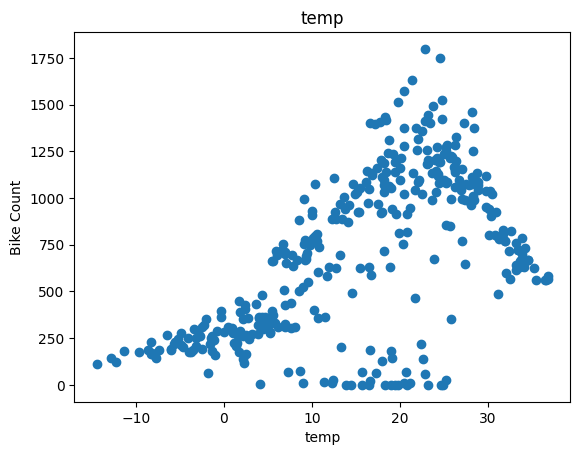

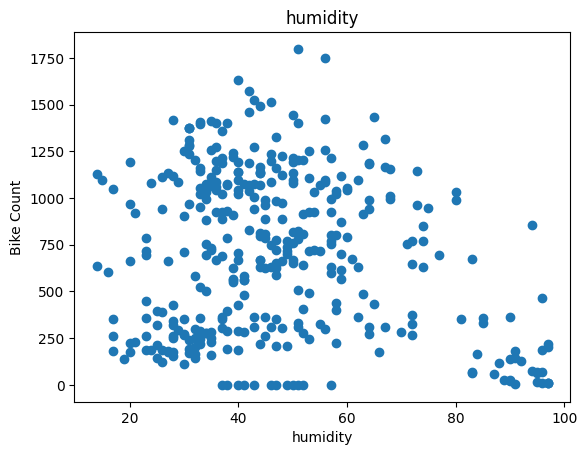

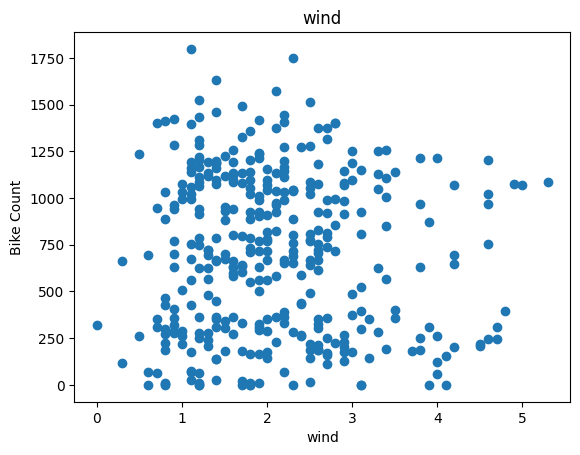

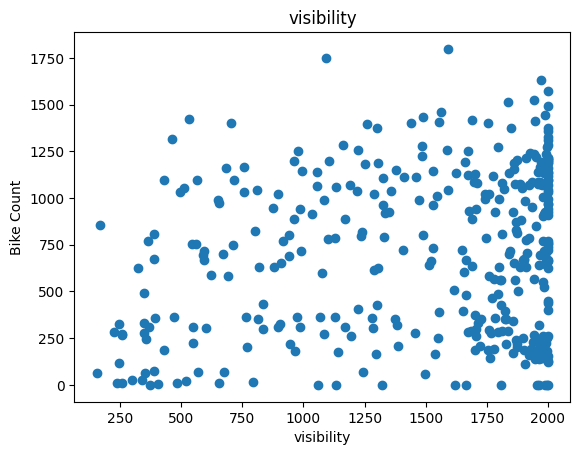

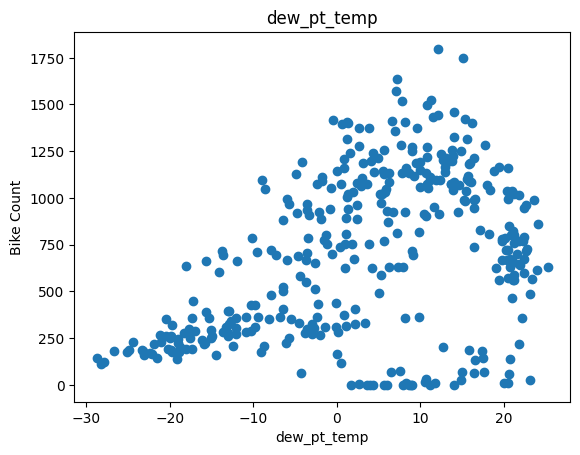

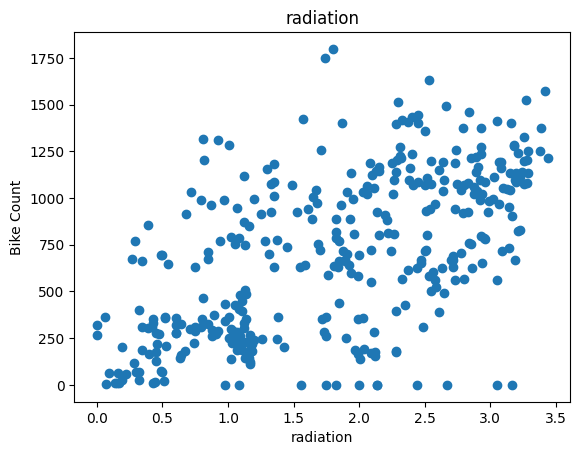

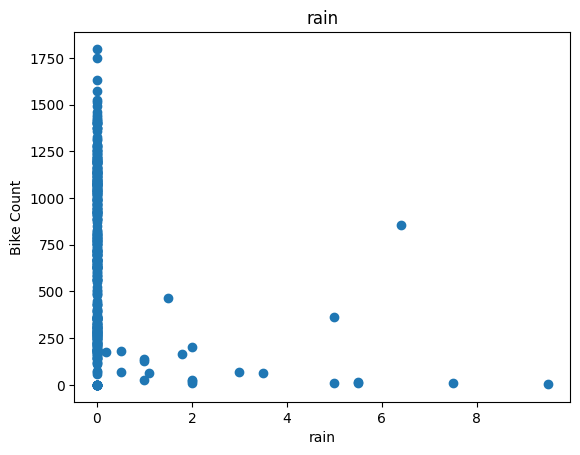

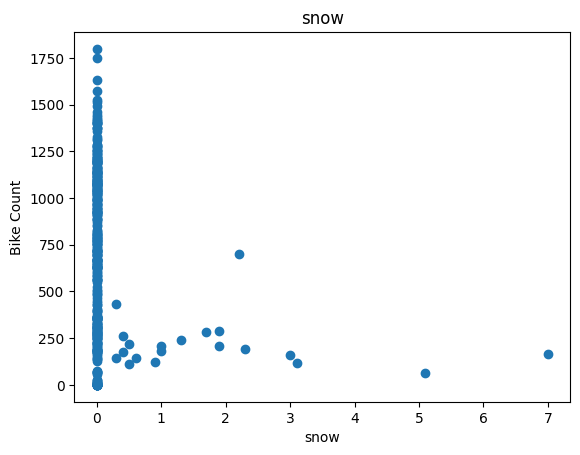

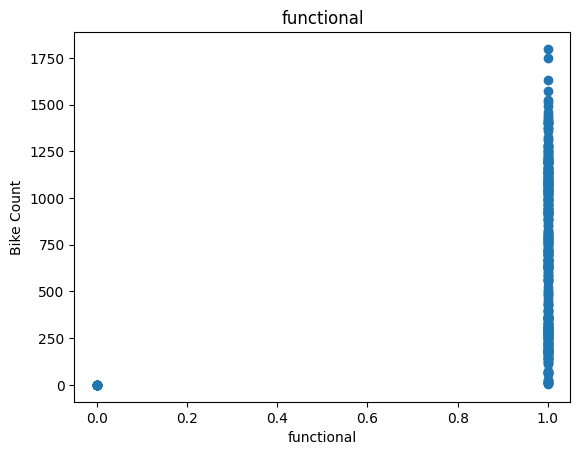

In [67]:
for col in df.columns[1:]:
     plt.scatter(df[col], df["bike_count"])
     plt.title(col)
     plt.ylabel("Bike Count")
     plt.xlabel(col)
     plt.show()

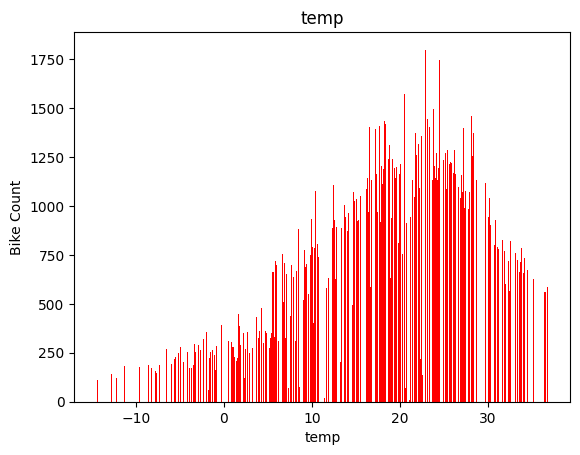

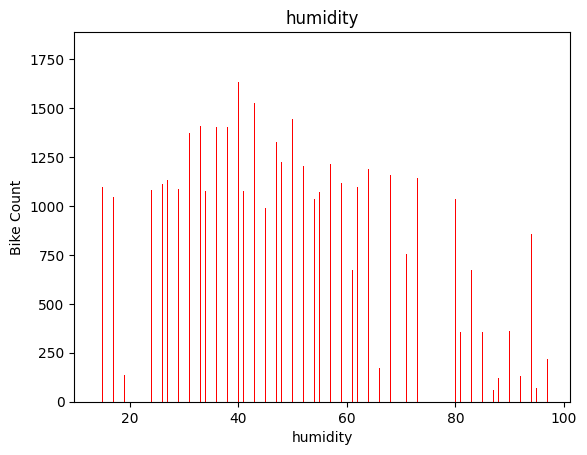

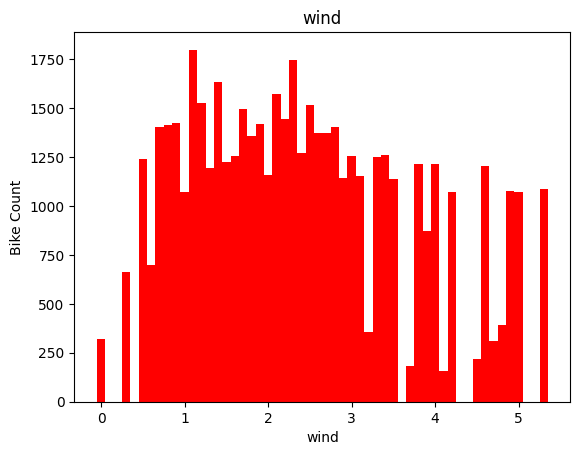

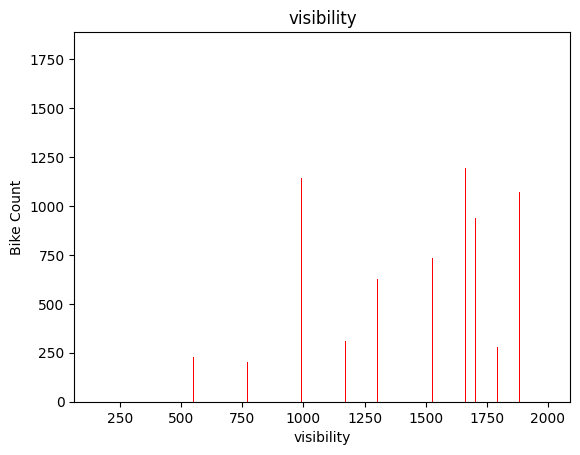

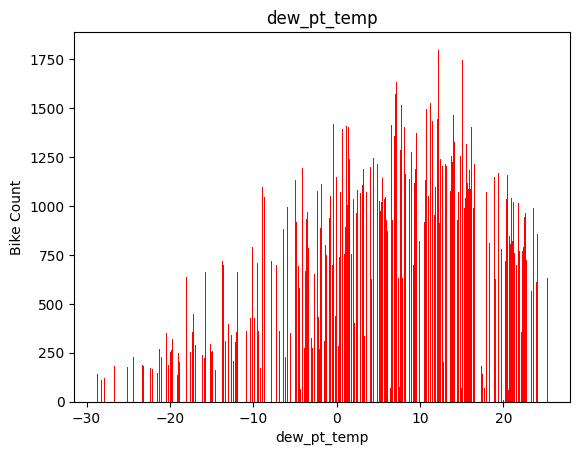

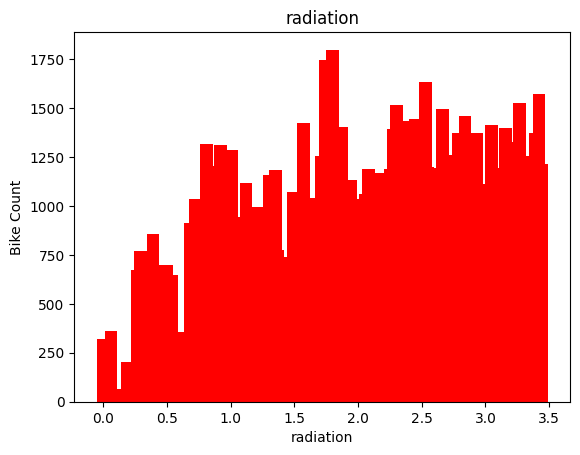

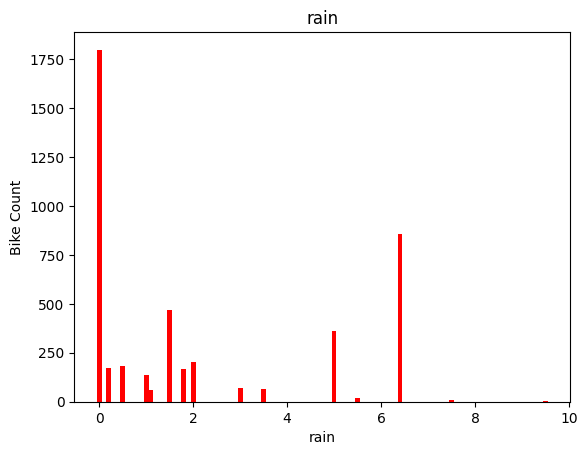

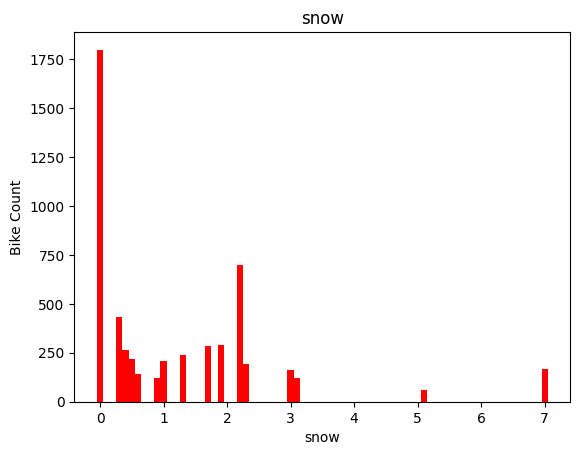

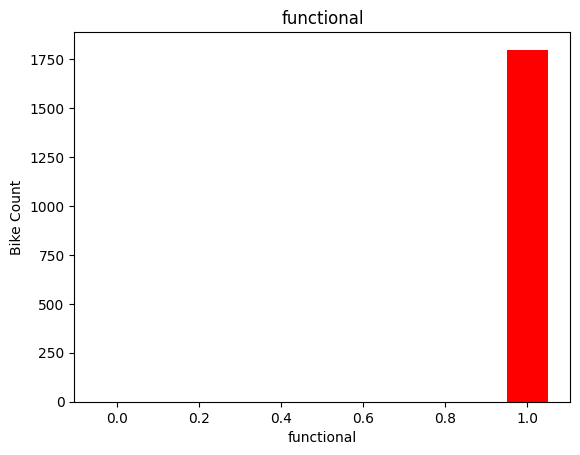

In [69]:
for col in df.columns[1:]:
    plt.bar(df[col], df['bike_count'] , color="red" , width=0.1  )
    plt.title(col)
    plt.ylabel("Bike Count")
    plt.xlabel(col)
    plt.show()

# train valid test dataset

In [70]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [71]:
# data for only temp
X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])
# data for all cols
X_train , y_train = get_xy(train, "bike_count")
X_val , y_val = get_xy(val, "bike_count")
X_test , y_test = get_xy(test, "bike_count")

# LINEAR REGRESSION

In [72]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [73]:
print(
# coefficent of formula
temp_reg.coef_ ,
#
temp_reg.intercept_ ,
temp_reg.score(X_test_temp, y_test_temp))

[[23.00665702]] [361.73180606] 0.14534343031029995


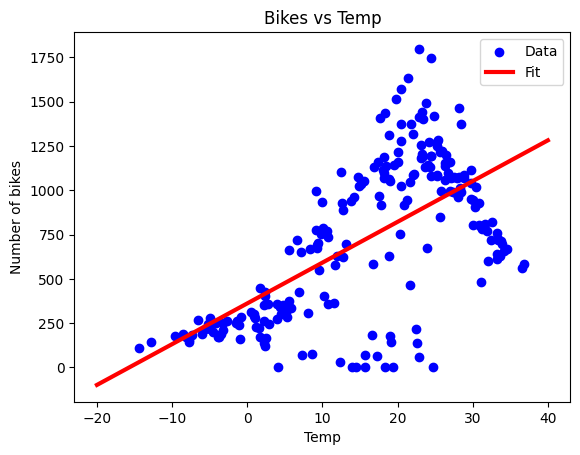

In [74]:
plt_reg(temp_reg , X_train_temp , y_train_temp)

# MULTIPLE LINEAR REGRESSION

In [75]:
multi_reg = LinearRegression()
multi_reg.fit(X_train, y_train)

LinearRegression()

In [96]:
multi_reg.score(X_test , y_test)

0.5322606282035482

# ***LINEAR REGRESSION WITH NERUAL NET*** (only one node)

In [76]:
temp_normalizer = tf.keras.layers.Normalization(axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

temp_nn_model = tf.keras.Sequential((
    tf.keras.Input(shape=(1,)),
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
))

In [77]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [78]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

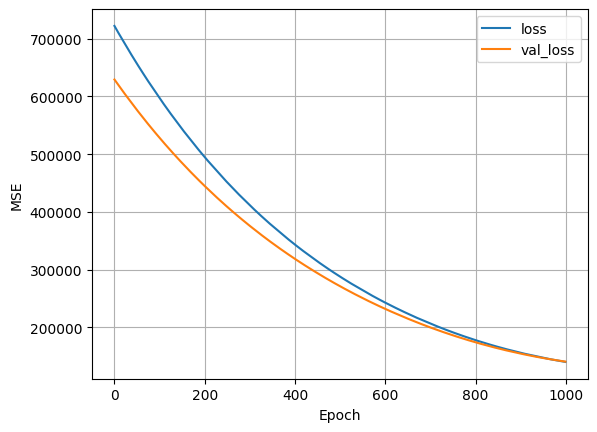

In [79]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


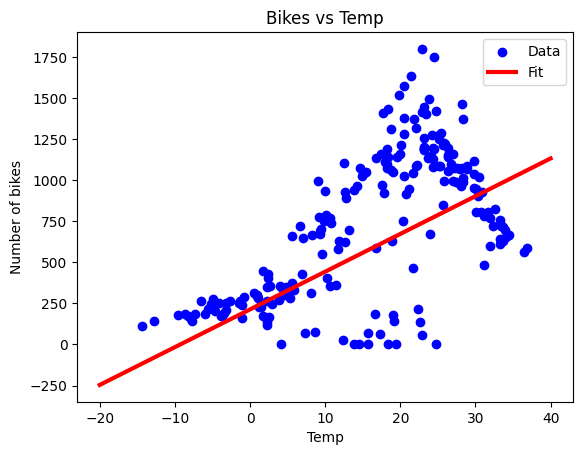

In [80]:
plt_reg(temp_nn_model , X_train_temp , y_train_temp);

# ***MULTIPLE LINEAR REGRESSION WITH NERUAL NET*** (only one node)

In [81]:
num_cols = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

multi_nn_model = tf.keras.Sequential((
    tf.keras.Input(shape=(num_cols,)),
    normalizer,
    tf.keras.layers.Dense(units=1)
))

In [82]:
multi_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [115]:
history = multi_nn_model.fit(
    X_train, y_train,
    epochs=1000,
    verbose=0,
    validation_data=(X_val, y_val)
)

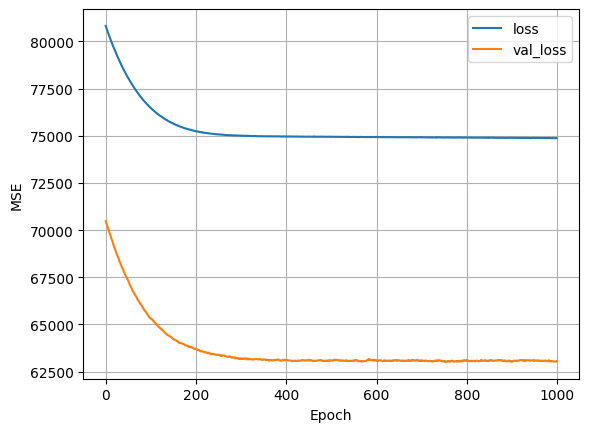

In [117]:
plot_loss(history)

# **LINEAR REGRESSION WITH NERUAL NET**

In [84]:
# Normalization transforms your data into a range between 0 and 1
temp_normalizer = tf.keras.layers.Normalization(axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

temp_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    temp_normalizer,
    tf.keras.layers.Dense(32 ,activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [85]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [86]:
history = temp_nn_model.fit(
    X_train_temp , y_train_temp,
    epochs=100,
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

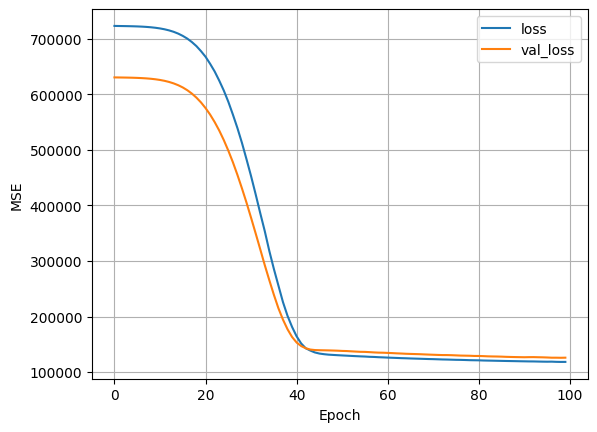

In [87]:
plot_loss(history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


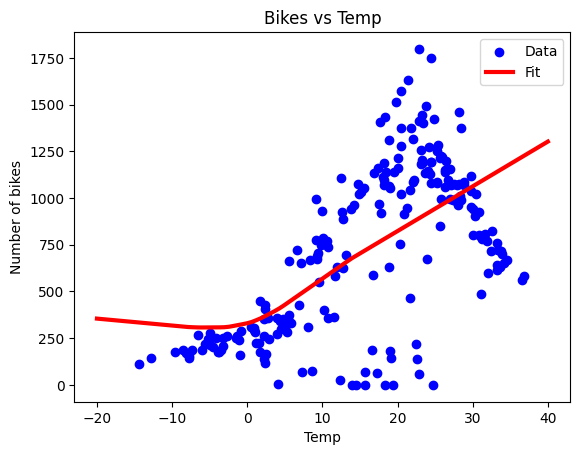

In [88]:
# plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
# x = np.linspace(-20, 40, 100)
# plt.plot(x, temp_nn_model.predict(x.reshape(-1,1)), label="Fit", color="red", linewidth=3)
# plt.legend()
# plt.title("Bikes vs Temp")
# plt.ylabel("Number of bikes")
# plt.xlabel("Temp")
# plt.show()
plt_reg(temp_nn_model , X_train_temp , y_train_temp)

# MULTIPLE LINEAR REGRESSION WITH NERUAL NET

In [108]:
# axis=-1 normalize all col
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

cols_len = X_train.shape[1]

multi_nn_model = tf.keras.Sequential((
    tf.keras.Input(shape=(cols_len,)),
    normalizer,
    tf.keras.layers.Dense(32 ,activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
))

In [109]:
multi_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [112]:
history = multi_nn_model.fit(
    X_train , y_train,
    epochs=1000,
    verbose=0,
    validation_data=(X_val, y_val)
)

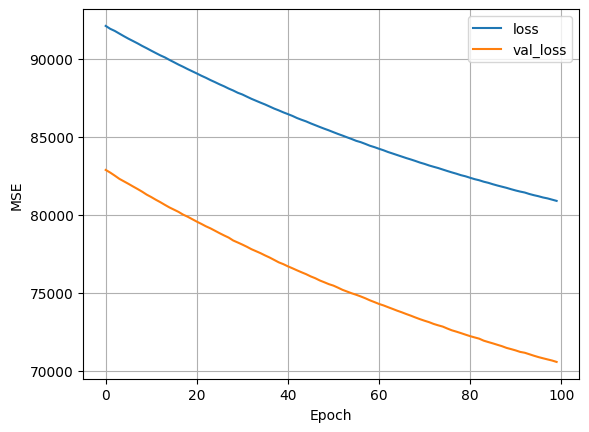

In [113]:
plot_loss(history)